<a href="https://colab.research.google.com/github/aakanksha215/BoneAbnormalityDetection/blob/main/BoneAbnormality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Data Loading**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from collections import defaultdict

In [3]:
BASE_DIR = '/content/drive/MyDrive/medicaldataset/bone/MURA-v1.1'
print("Base exists:", os.path.exists(BASE_DIR))

Base exists: True


In [4]:
!ls /content/drive/MyDrive/medicaldataset/bone

MURA-v1.1


In [5]:
!ls /content/drive/MyDrive/medicaldataset/bone/MURA-v1.1

train		       train_labeled_studies.csv  valid_image_paths.csv
train_image_paths.csv  valid			  valid_labeled_studies.csv


In [6]:
print("Base:", os.path.exists(BASE_DIR))
print("Train folder:", os.path.exists(os.path.join(BASE_DIR, 'train')))
print("CSV:", os.path.exists(os.path.join(BASE_DIR, 'train_image_paths.csv')))

Base: True
Train folder: True
CSV: True


In [7]:

df_img = pd.read_csv(
    os.path.join(BASE_DIR, 'train_image_paths.csv'),
    header=None,
    names=['image_path_csv']
)

df_img.head()

,image_path_csv
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...


In [8]:
df_img['relative_path'] = df_img['image_path_csv'].apply(
    lambda x: x.replace('MURA-v1.1/', '').strip()
)

In [9]:
print(df_img['relative_path'].iloc[0])

train/XR_SHOULDER/patient00001/study1_positive/image1.png


In [10]:
df_img['image_path'] = df_img['relative_path'].apply(
    lambda x: os.path.join(BASE_DIR, x)
)

In [11]:
print(df_img['image_path'].iloc[0])
print("Exists:", os.path.exists(df_img['image_path'].iloc[0]))

/content/drive/MyDrive/medicaldataset/bone/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png
Exists: True


In [12]:
df_img['study_path'] = df_img['image_path'].apply(
    lambda x: x.split('train/')[1].rsplit('/', 1)[0]
)

df_img.head()

,image_path_csv,relative_path,image_path,study_path
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,train/XR_SHOULDER/patient00001/study1_positive...,/content/drive/MyDrive/medicaldataset/bone/MUR...,XR_SHOULDER/patient00001/study1_positive
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,train/XR_SHOULDER/patient00001/study1_positive...,/content/drive/MyDrive/medicaldataset/bone/MUR...,XR_SHOULDER/patient00001/study1_positive
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,train/XR_SHOULDER/patient00001/study1_positive...,/content/drive/MyDrive/medicaldataset/bone/MUR...,XR_SHOULDER/patient00001/study1_positive
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,train/XR_SHOULDER/patient00002/study1_positive...,/content/drive/MyDrive/medicaldataset/bone/MUR...,XR_SHOULDER/patient00002/study1_positive
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,train/XR_SHOULDER/patient00002/study1_positive...,/content/drive/MyDrive/medicaldataset/bone/MUR...,XR_SHOULDER/patient00002/study1_positive


In [13]:
df_label = pd.read_csv(
    os.path.join(BASE_DIR, 'train_labeled_studies.csv'),
    header=None,
    names=['raw_study_path', 'label']
)

df_label['study_path'] = df_label['raw_study_path'].apply(
    lambda x: x.replace('MURA-v1.1/train/', '').strip('/')
)

In [14]:
df = df_img.merge(
    df_label[['study_path', 'label']],
    on='study_path',
    how='left'
)

print(df.head())
print("Missing labels:", df['label'].isna().sum())

                                      image_path_csv  \
0  MURA-v1.1/train/XR_SHOULDER/patient00001/study...   
1  MURA-v1.1/train/XR_SHOULDER/patient00001/study...   
2  MURA-v1.1/train/XR_SHOULDER/patient00001/study...   
3  MURA-v1.1/train/XR_SHOULDER/patient00002/study...   
4  MURA-v1.1/train/XR_SHOULDER/patient00002/study...   

                                       relative_path  \
0  train/XR_SHOULDER/patient00001/study1_positive...   
1  train/XR_SHOULDER/patient00001/study1_positive...   
2  train/XR_SHOULDER/patient00001/study1_positive...   
3  train/XR_SHOULDER/patient00002/study1_positive...   
4  train/XR_SHOULDER/patient00002/study1_positive...   

                                          image_path  \
0  /content/drive/MyDrive/medicaldataset/bone/MUR...   
1  /content/drive/MyDrive/medicaldataset/bone/MUR...   
2  /content/drive/MyDrive/medicaldataset/bone/MUR...   
3  /content/drive/MyDrive/medicaldataset/bone/MUR...   
4  /content/drive/MyDrive/medicaldataset/bone/

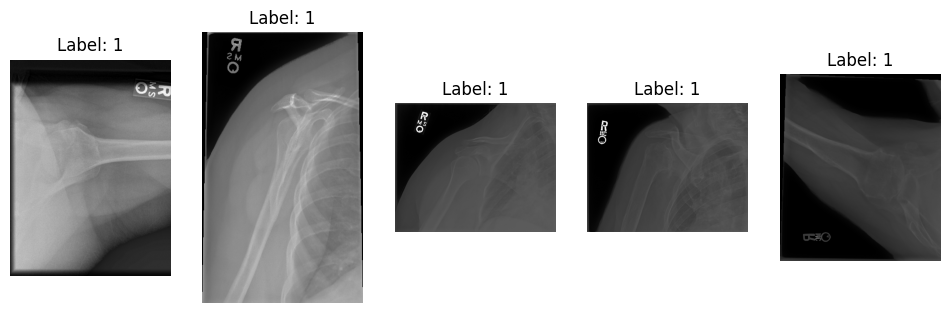

In [15]:
plt.figure(figsize=(12,4))
for i in range(5):
    img = cv2.imread(df.iloc[i]['image_path'], cv2.IMREAD_GRAYSCALE)
    plt.subplot(1,5,i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Label: {df.iloc[i]['label']}")
    plt.axis('off')
plt.show()

Label counts:
 label
0    21935
1    14873
Name: count, dtype: int64


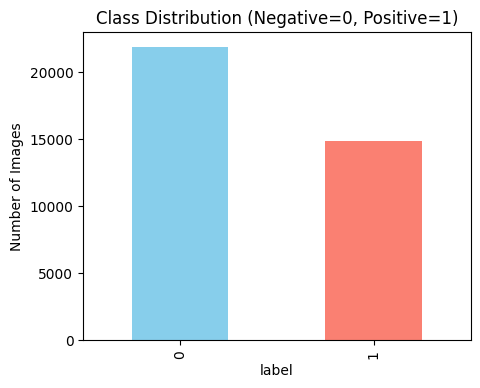

In [16]:
# Check label distribution (positive/negative)
import matplotlib.pyplot as plt

# Count of labels
label_counts = df['label'].value_counts()
print("Label counts:\n", label_counts)

# Plot
plt.figure(figsize=(5,4))
label_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title("Class Distribution (Negative=0, Positive=1)")
plt.ylabel("Number of Images")
plt.show()

Images per body part:
 body_part
XR_WRIST       9752
XR_SHOULDER    8379
XR_HAND        5543
XR_FINGER      5106
XR_ELBOW       4931
XR_FOREARM     1825
XR_HUMERUS     1272
Name: count, dtype: int64


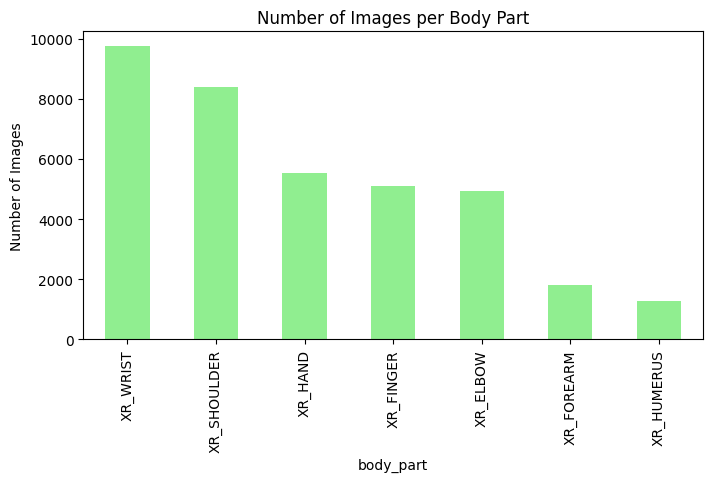

In [17]:
# Check distribution across body parts

df['body_part'] = df['study_path'].apply(lambda x: x.split('/')[0])

# Count per body part
body_counts = df['body_part'].value_counts()
print("Images per body part:\n", body_counts)

# Plot
plt.figure(figsize=(8,4))
body_counts.plot(kind='bar', color='lightgreen')
plt.title("Number of Images per Body Part")
plt.ylabel("Number of Images")
plt.show()

Images per study (summary):
 count    13457.000000
mean         2.735231
std          0.885611
min          1.000000
25%          2.000000
50%          3.000000
75%          3.000000
max         11.000000
Name: image_path, dtype: float64


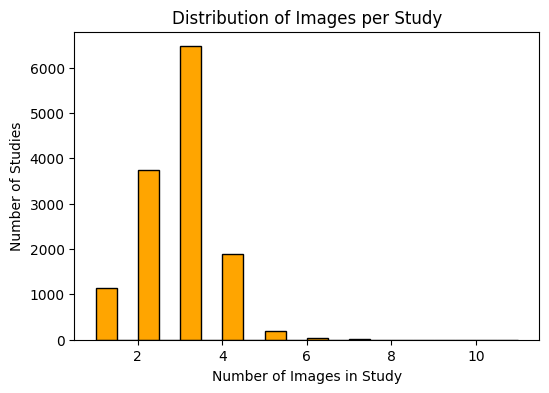

In [18]:
# Check number of images per study
images_per_study = df.groupby('study_path')['image_path'].count()
print("Images per study (summary):\n", images_per_study.describe())

# Histogram
plt.figure(figsize=(6,4))
plt.hist(images_per_study, bins=20, color='orange', edgecolor='black')
plt.title("Distribution of Images per Study")
plt.xlabel("Number of Images in Study")
plt.ylabel("Number of Studies")
plt.show()

In [19]:
# Image Size

sample_paths = df['image_path'].sample(100, random_state=42)

sizes = []
for path in sample_paths:
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        sizes.append(img.shape)

# Convert to numpy
sizes = np.array(sizes)
print("Image sizes (h, w): min={}, max={}".format(sizes.min(axis=0), sizes.max(axis=0)))

Image sizes (h, w): min=[292 218], max=[512 512]


Positive vs Negative distribution per body part:

label           0     1
body_part              
XR_ELBOW     2925  2006
XR_FINGER    3138  1968
XR_FOREARM   1164   661
XR_HAND      4059  1484
XR_HUMERUS    673   599
XR_SHOULDER  4211  4168
XR_WRIST     5765  3987


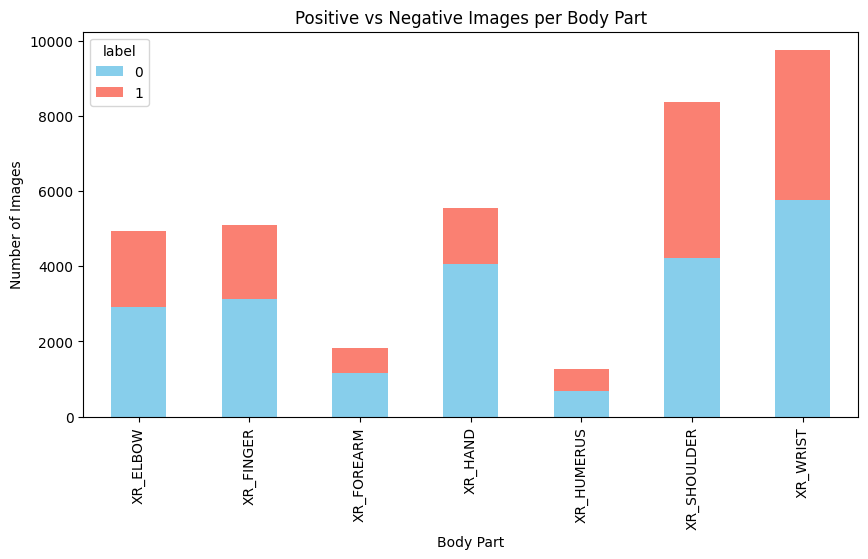

In [20]:
# Positive vs Negative distribution per body part

body_parts = df['body_part'].unique()
pos_neg_counts = df.groupby(['body_part', 'label']).size().unstack(fill_value=0)

print("Positive vs Negative distribution per body part:\n")
print(pos_neg_counts)

pos_neg_counts.plot(kind='bar', stacked=True, figsize=(10,5), color=['skyblue','salmon'])
plt.title("Positive vs Negative Images per Body Part")
plt.ylabel("Number of Images")
plt.xlabel("Body Part")
plt.show()

Average number of images per study for each body part:
 body_part
XR_ELBOW       2.811288
XR_FINGER      2.638760
XR_FOREARM     2.080958
XR_HAND        2.746779
XR_HUMERUS     2.148649
XR_SHOULDER    2.970223
XR_WRIST       2.818497
Name: image_path, dtype: float64


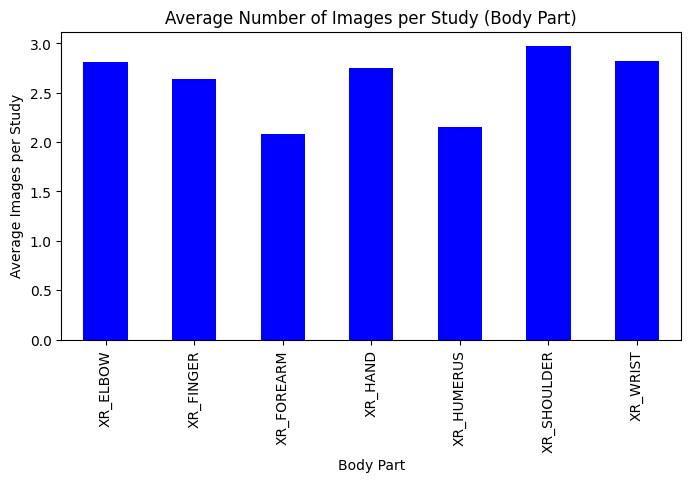

In [21]:
# Average number of images per study for each body part
images_per_study = df.groupby(['body_part','study_path'])['image_path'].count()
avg_images_per_study = images_per_study.groupby('body_part').mean()

print("Average number of images per study for each body part:\n", avg_images_per_study)

plt.figure(figsize=(8,4))
avg_images_per_study.plot(kind='bar', color='blue')
plt.title("Average Number of Images per Study (Body Part)")
plt.ylabel("Average Images per Study")
plt.xlabel("Body Part")
plt.show()


Study: XR_FINGER/patient03477/study1_positive, Label: 1, Total Images: 3


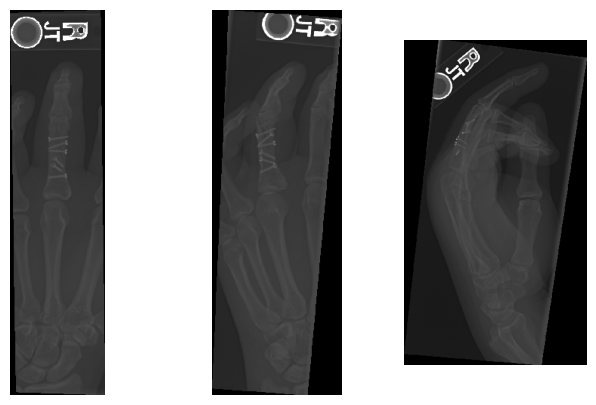


Study: XR_HAND/patient10041/study1_positive, Label: 1, Total Images: 2


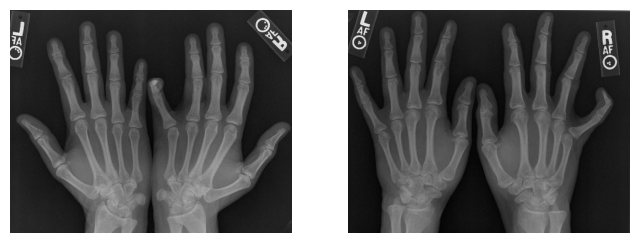


Study: XR_WRIST/patient05090/study2_negative, Label: 0, Total Images: 3


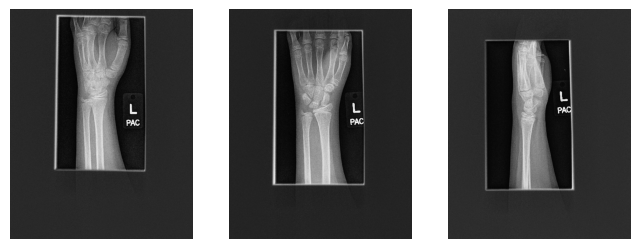

In [22]:
# Visualize some example studies fully

example_studies = df['study_path'].drop_duplicates().sample(3, random_state=42)

for study in example_studies:
    study_images = df[df['study_path']==study]
    print(f"\nStudy: {study}, Label: {study_images['label'].iloc[0]}, Total Images: {len(study_images)}")

    plt.figure(figsize=(8,5))
    for i, row in enumerate(study_images.itertuples()):
        img = cv2.imread(row.image_path, cv2.IMREAD_GRAYSCALE)
        plt.subplot(1,len(study_images), i+1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.show()


Image sizes (h, w) min, max, mean:
Min: [292 218] Max: [512 512] Mean: [478.82 430.9 ]


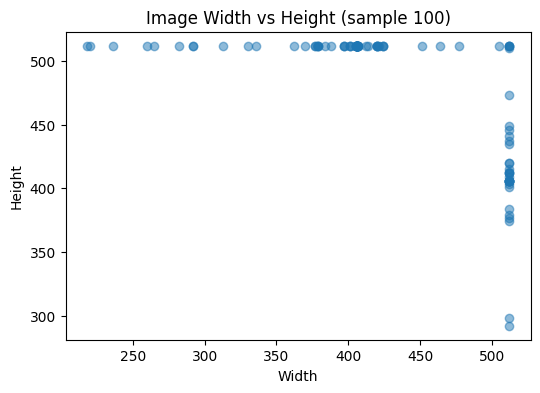

In [23]:
# Image size stats (sample 100 images)

sample_paths = df['image_path'].sample(100, random_state=42)
sizes = []
for path in sample_paths:
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        sizes.append(img.shape)

sizes = np.array(sizes)
print("\nImage sizes (h, w) min, max, mean:")
print("Min:", sizes.min(axis=0), "Max:", sizes.max(axis=0), "Mean:", sizes.mean(axis=0))

plt.figure(figsize=(6,4))
plt.scatter(sizes[:,1], sizes[:,0], alpha=0.5)
plt.title("Image Width vs Height (sample 100)")
plt.xlabel("Width")
plt.ylabel("Height")
plt.show()

In [24]:
df['body_part'] = df['study_path'].apply(lambda x: x.split('/')[0])

In [25]:
df[['study_path', 'body_part', 'label']].head()

,study_path,body_part,label
0,XR_SHOULDER/patient00001/study1_positive,XR_SHOULDER,1
1,XR_SHOULDER/patient00001/study1_positive,XR_SHOULDER,1
2,XR_SHOULDER/patient00001/study1_positive,XR_SHOULDER,1
3,XR_SHOULDER/patient00002/study1_positive,XR_SHOULDER,1
4,XR_SHOULDER/patient00002/study1_positive,XR_SHOULDER,1


In [26]:
def show_pos_neg_sample(body_part, df):
    subset = df[df['body_part'] == body_part]

    pos = subset[subset['label'] == 1]
    neg = subset[subset['label'] == 0]

    if pos.empty or neg.empty:
        print(f"Skipping {body_part}: missing pos or neg")
        return

    pos_img_path = pos.iloc[0]['image_path']
    neg_img_path = neg.iloc[0]['image_path']

    pos_img = cv2.imread(pos_img_path, cv2.IMREAD_GRAYSCALE)
    neg_img = cv2.imread(neg_img_path, cv2.IMREAD_GRAYSCALE)

    plt.figure(figsize=(6, 3))

    plt.subplot(1, 2, 1)
    plt.imshow(pos_img, cmap='gray')
    plt.title(f"{body_part}\nPOSITIVE")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(neg_img, cmap='gray')
    plt.title(f"{body_part}\nNEGATIVE")
    plt.axis('off')

    plt.show()

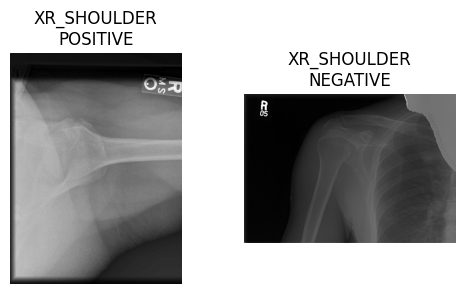

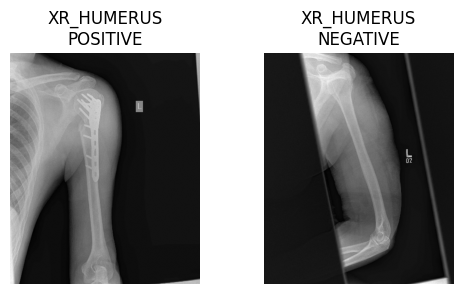

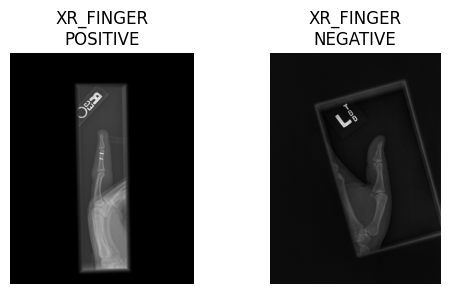

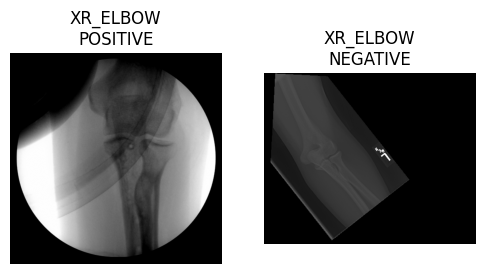

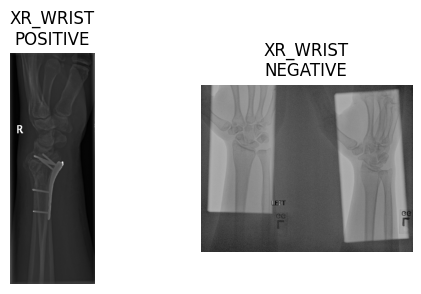

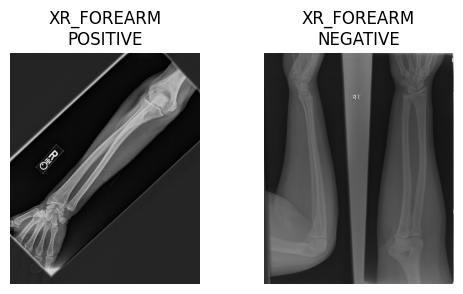

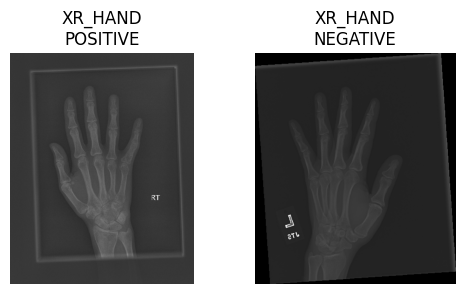

In [27]:
body_parts = df['body_part'].unique()

for bp in body_parts:
    show_pos_neg_sample(bp, df)

In [28]:
def extract_patient_id(path):
    return path.split('/')[-3]

df['patient_id'] = df['image_path'].apply(extract_patient_id)

In [29]:
num_patients = df['patient_id'].nunique()
print("Total patients:", num_patients)

Total patients: 11184


In [30]:
df['body_part'] = df['image_path'].apply(lambda x: x.split('/')[-4])

patients_per_body_part = (
    df.groupby('body_part')['patient_id']
      .nunique()
      .sort_values(ascending=False)
)

print(patients_per_body_part)

body_part
XR_WRIST       3267
XR_SHOULDER    2694
XR_HAND        1945
XR_FINGER      1865
XR_ELBOW       1711
XR_FOREARM      865
XR_HUMERUS      587
Name: patient_id, dtype: int64


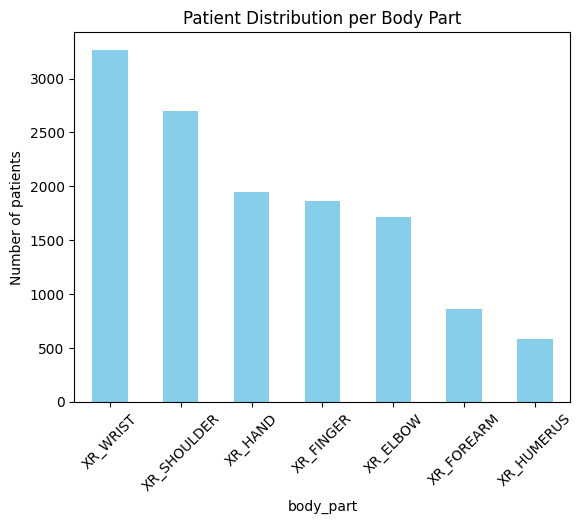

In [31]:
import matplotlib.pyplot as plt

patients_per_body_part.plot(kind='bar', color='skyblue')
plt.ylabel("Number of patients")
plt.title("Patient Distribution per Body Part")
plt.xticks(rotation=45)
plt.show()

In [32]:
patients_per_label = (
    df.groupby('label')['patient_id']
      .nunique()
)

print(patients_per_label)

label
0    7272
1    4800
Name: patient_id, dtype: int64


In [33]:
summary = df.groupby('body_part').agg(
    num_images=('image_path', 'count'),
    num_studies=('study_path', 'nunique'),
    num_patients=('patient_id', 'nunique')
)

print(summary)

             num_images  num_studies  num_patients
body_part                                         
XR_ELBOW           4931         1754          1711
XR_FINGER          5106         1935          1865
XR_FOREARM         1825          877           865
XR_HAND            5543         2018          1945
XR_HUMERUS         1272          592           587
XR_SHOULDER        8379         2821          2694
XR_WRIST           9752         3460          3267


**3. Preprocessing**

In [34]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [35]:
print("Before filtering:", len(df))

Before filtering: 36808


In [36]:
df = df[df['image_path'].apply(os.path.exists)].reset_index(drop=True)

In [37]:
print("After filtering:", len(df))

After filtering: 36765


In [38]:
from sklearn.model_selection import train_test_split

# Get all unique patients
patients = df['patient_id'].unique()

# Step 1: Split train vs temp (val+test)
train_patients, temp_patients = train_test_split(
    patients, test_size=0.3, random_state=42
)

# Step 2: Split temp into val and test
val_patients, test_patients = train_test_split(
    temp_patients, test_size=0.5, random_state=42
)

# Filter dataframe
train_df = df[df['patient_id'].isin(train_patients)].reset_index(drop=True)
val_df   = df[df['patient_id'].isin(val_patients)].reset_index(drop=True)
test_df  = df[df['patient_id'].isin(test_patients)].reset_index(drop=True)

print("Train patients:", train_df['patient_id'].nunique())
print("Val patients:", val_df['patient_id'].nunique())
print("Test patients:", test_df['patient_id'].nunique())

print("Train images:", len(train_df))
print("Val images:", len(val_df))
print("Test images:", len(test_df))

Train patients: 7828
Val patients: 1678
Test patients: 1678
Train images: 25843
Val images: 5382
Test images: 5540


In [39]:
# Report body-part distribution

In [40]:
for split_name, split_df in zip(['Train','Val','Test'], [train_df, val_df, test_df]):
    print(f"\n{split_name} label distribution:")
    print(split_df['label'].value_counts())


Train label distribution:
label
0    15294
1    10549
Name: count, dtype: int64

Val label distribution:
label
0    3168
1    2214
Name: count, dtype: int64

Test label distribution:
label
0    3445
1    2095
Name: count, dtype: int64


In [41]:
splits = {'Train': train_df, 'Validation': val_df, 'Test': test_df}

for split_name, split_df in splits.items():
    patients_per_body_part = split_df.groupby('body_part')['patient_id'].nunique()
    print(f"\n{split_name} - Patients per body part:")
    print(patients_per_body_part)


Train - Patients per body part:
body_part
XR_ELBOW       1198
XR_FINGER      1306
XR_FOREARM      600
XR_HAND        1383
XR_HUMERUS      406
XR_SHOULDER    1866
XR_WRIST       2305
Name: patient_id, dtype: int64

Validation - Patients per body part:
body_part
XR_ELBOW       257
XR_FINGER      282
XR_FOREARM     139
XR_HAND        270
XR_HUMERUS      90
XR_SHOULDER    408
XR_WRIST       462
Name: patient_id, dtype: int64

Test - Patients per body part:
body_part
XR_ELBOW       246
XR_FINGER      277
XR_FOREARM     126
XR_HAND        292
XR_HUMERUS      91
XR_SHOULDER    420
XR_WRIST       500
Name: patient_id, dtype: int64


In [42]:
def body_part_counts(df, name):
    print(f"\n{name} body-part distribution:")
    print(df['study_path'].str.split('/').str[0].value_counts())

body_part_counts(train_df, "Train")
body_part_counts(val_df, "Val")
body_part_counts(test_df, "Test")


Train body-part distribution:
study_path
XR_WRIST       6905
XR_SHOULDER    5845
XR_HAND        3912
XR_FINGER      3564
XR_ELBOW       3465
XR_FOREARM     1276
XR_HUMERUS      876
Name: count, dtype: int64

Val body-part distribution:
study_path
XR_WRIST       1357
XR_SHOULDER    1215
XR_HAND         804
XR_FINGER       774
XR_ELBOW        752
XR_FOREARM      284
XR_HUMERUS      196
Name: count, dtype: int64

Test body-part distribution:
study_path
XR_WRIST       1490
XR_SHOULDER    1319
XR_HAND         827
XR_FINGER       768
XR_ELBOW        671
XR_FOREARM      265
XR_HUMERUS      200
Name: count, dtype: int64


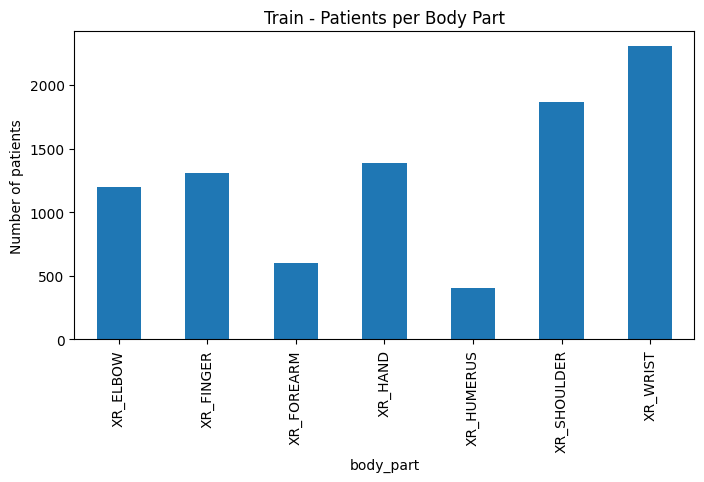

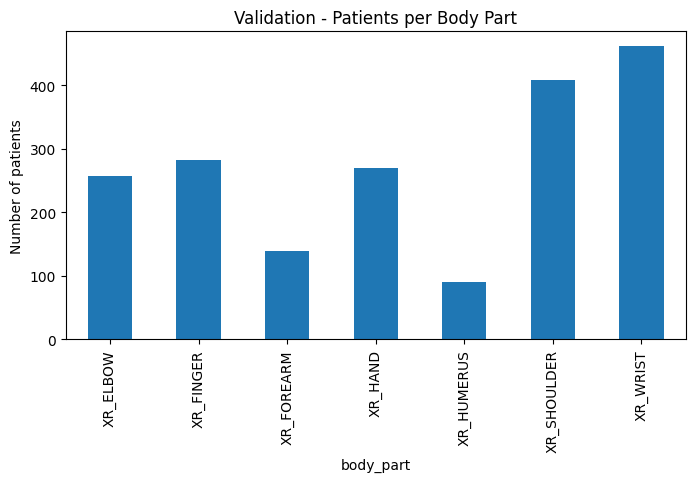

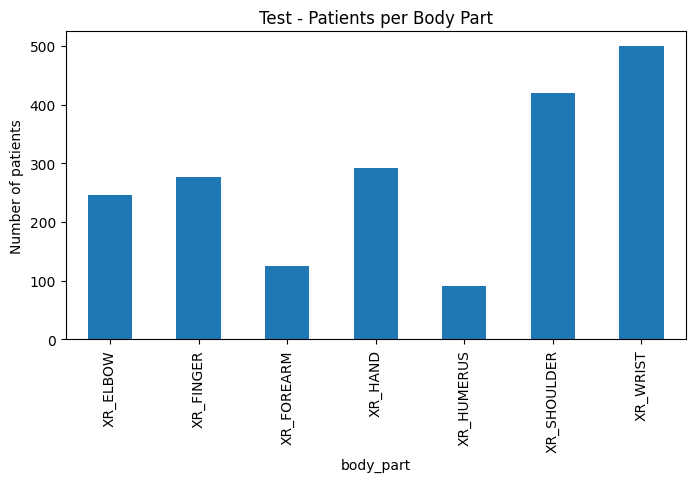

In [43]:
import matplotlib.pyplot as plt

for split_name, split_df in splits.items():
    patients_per_body_part = split_df.groupby('body_part')['patient_id'].nunique()
    patients_per_body_part.plot(kind='bar', figsize=(8,4), title=f"{split_name} - Patients per Body Part")
    plt.ylabel("Number of patients")
    plt.show()

In [44]:
def extract_body_part(study_path):
    return study_path.split('/')[0]

df['body_part'] = df['study_path'].apply(extract_body_part)

In [45]:
def report_body_part_images(df, name):
    print(f"\n{name} image-level distribution:")
    display(
        df['body_part']
        .value_counts()
        .rename("num_images")
        .to_frame()
    )

report_body_part_images(train_df, "Train")
report_body_part_images(val_df, "Validation")
report_body_part_images(test_df, "Test")


Train image-level distribution:


,num_images
body_part,
XR_WRIST,6905
XR_SHOULDER,5845
XR_HAND,3912
XR_FINGER,3564
XR_ELBOW,3465
XR_FOREARM,1276
XR_HUMERUS,876



Validation image-level distribution:


,num_images
body_part,
XR_WRIST,1357
XR_SHOULDER,1215
XR_HAND,804
XR_FINGER,774
XR_ELBOW,752
XR_FOREARM,284
XR_HUMERUS,196



Test image-level distribution:


,num_images
body_part,
XR_WRIST,1490
XR_SHOULDER,1319
XR_HAND,827
XR_FINGER,768
XR_ELBOW,671
XR_FOREARM,265
XR_HUMERUS,200


In [46]:
def report_body_part_studies(df, name):
    study_df = (
        df[['study_path', 'body_part']]
        .drop_duplicates()
    )

    print(f"\n{name} study-level distribution:")
    display(
        study_df['body_part']
        .value_counts()
        .rename("num_studies")
        .to_frame()
    )

report_body_part_studies(train_df, "Train")
report_body_part_studies(val_df, "Validation")
report_body_part_studies(test_df, "Test")


Train study-level distribution:


,num_studies
body_part,
XR_WRIST,2447
XR_SHOULDER,1955
XR_HAND,1429
XR_FINGER,1353
XR_ELBOW,1228
XR_FOREARM,606
XR_HUMERUS,410



Validation study-level distribution:


,num_studies
body_part,
XR_WRIST,484
XR_SHOULDER,429
XR_FINGER,292
XR_HAND,287
XR_ELBOW,266
XR_FOREARM,142
XR_HUMERUS,90



Test study-level distribution:


,num_studies
body_part,
XR_WRIST,529
XR_SHOULDER,437
XR_HAND,302
XR_FINGER,290
XR_ELBOW,250
XR_FOREARM,129
XR_HUMERUS,92


In [47]:
def pos_neg_distribution(df, name):
    study_df = (
        df[['study_path', 'body_part', 'label']]
        .drop_duplicates()
    )

    table = (
        study_df
        .groupby(['body_part', 'label'])
        .size()
        .unstack(fill_value=0)
    )

    print(f"\n{name} Positive / Negative (study-level):")
    display(table)

pos_neg_distribution(train_df, "Train")
pos_neg_distribution(val_df, "Validation")
pos_neg_distribution(test_df, "Test")


Train Positive / Negative (study-level):


label,0,1
body_part,,
XR_ELBOW,749,479
XR_FINGER,886,467
XR_FOREARM,405,201
XR_HAND,1061,368
XR_HUMERUS,213,197
XR_SHOULDER,947,1008
XR_WRIST,1498,949



Validation Positive / Negative (study-level):


label,0,1
body_part,,
XR_ELBOW,166,100
XR_FINGER,199,93
XR_FOREARM,98,44
XR_HAND,211,76
XR_HUMERUS,51,39
XR_SHOULDER,203,226
XR_WRIST,285,199



Test Positive / Negative (study-level):


label,0,1
body_part,,
XR_ELBOW,171,79
XR_FINGER,195,95
XR_FOREARM,87,42
XR_HAND,225,77
XR_HUMERUS,57,35
XR_SHOULDER,214,223
XR_WRIST,351,178


In [48]:
import cv2
import numpy as np
import tensorflow as tf

def clahe_op(image):
    image = image.numpy().astype(np.uint8)

    clahe = cv2.createCLAHE(
        clipLimit=2.0,
        tileGridSize=(8, 8)
    )
    image = clahe.apply(image)

    return image

In [49]:
IMG_SIZE = 224

def preprocess_image_clahe(path, label):

    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=1)

    # Apply CLAHE
    image = tf.py_function(
        func=clahe_op,
        inp=[image],
        Tout=tf.uint8
    )
    image.set_shape([None, None])

    # Convert grayscale → RGB
    image = tf.expand_dims(image, axis=-1)
    image = tf.image.grayscale_to_rgb(image)

    # Resize & normalize
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0

    return image, label

In [50]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.02),
    layers.RandomZoom(0.05),
    layers.RandomContrast(0.05),
])

In [51]:
def preprocess_train_clahe(path, label):
    image, label = preprocess_image_clahe(path, label)
    image = data_augmentation(image)
    return image, label

In [52]:
def preprocess_val_clahe(path, label):
    return preprocess_image_clahe(path, label)

In [53]:
BATCH_SIZE = 32

train_ds = tf.data.Dataset.from_tensor_slices(
    (train_df['image_path'].values, train_df['label'].values)
)

train_ds = (
    train_ds
    .shuffle(1000)
    .map(preprocess_train_clahe, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [54]:
val_ds = (
    tf.data.Dataset.from_tensor_slices(
        (val_df['image_path'].values, val_df['label'].values)
    )
    .map(preprocess_val_clahe, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [55]:
for images, labels in train_ds.take(1):
    print(images.shape)
    break

(32, 224, 224, 3)


In [56]:
for images, labels in train_ds.take(1):
    img = images[0]
    print("Min:", tf.reduce_min(img).numpy())
    print("Max:", tf.reduce_max(img).numpy())
    break

Min: 0.0628345
Max: 0.995221


In [57]:
def show_augmented_batch(images, labels, n=6):
    plt.figure(figsize=(12, 6))
    for i in range(n):
        plt.subplot(2, 3, i+1)
        plt.imshow(images[i].numpy())
        plt.title(f"Label: {int(labels[i])}")
        plt.axis("off")
    plt.show()

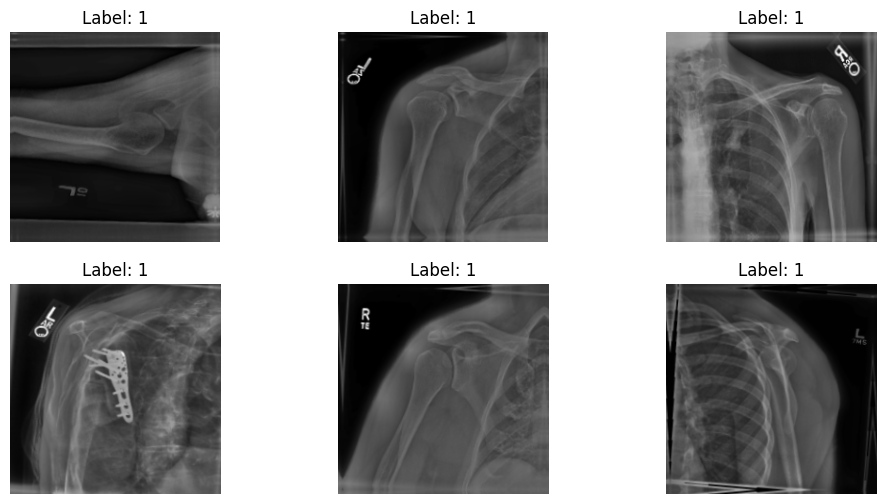

In [58]:
for images, labels in train_ds.take(1):
    show_augmented_batch(images, labels)

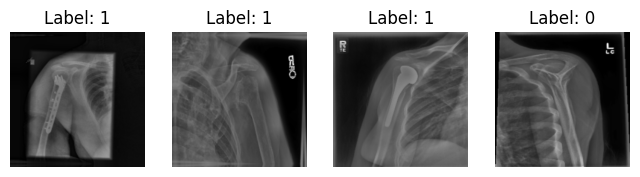

In [59]:
images, labels = next(iter(train_ds))

import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(images[i])
    plt.title(f"Label: {int(labels[i])}")
    plt.axis('off')
plt.show()

In [60]:
for images, labels in train_ds.take(1):
    print("Images shape:", images.shape)
    print("Single image shape:", images[0].shape)

Images shape: (32, 224, 224, 3)
Single image shape: (224, 224, 3)


In [61]:
images, labels = next(iter(train_ds))

print("Batch image shape:", images.shape)
print("Batch labels:", labels.numpy())

Batch image shape: (32, 224, 224, 3)
Batch labels: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0]


5. Prepare Model

In [77]:
from tensorflow.keras.applications import DenseNet121, InceptionV3, EfficientNetB0, EfficientNetB3, ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Concatenate, Input, Conv2D, Activation
from tensorflow.keras.models import Model
import tensorflow as tf

In [78]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=train_df['label'].values
)

class_weight = {
    0: class_weights[0],
    1: class_weights[1]
}

In [84]:
base_model2 = DenseNet121(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

for layer in base_model2.layers:
    layer.trainable = False

x = base_model2.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.4)(x)

x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)

output = Dense(1, activation="sigmoid")(x)
model2 = Model(inputs=base_model2.input, outputs=output)

In [88]:
optimizer = tf.keras.optimizers.AdamW(
    learning_rate=1e-4,
    weight_decay=1e-4
)

model2.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name="accuracy")
    ]
)

In [89]:
model2.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_4    │ (None, 230, 230,  │          0 │ input_layer_5[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_4… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_5    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_5… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,337,025 (27.99 MB)

 Trainable params: 297,473 (1.13 MB)

 Non-trainable params: 7,039,552 (26.85 MB)

In [90]:
history = model2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    class_weight=class_weight
)

Epoch 1/5
808/808 ━━━━━━━━━━━━━━━━━━━━ 4878s 6s/step - accuracy: 0.6650 - loss: 0.6605 - val_accuracy: 0.5923 - val_loss: 0.9259
Epoch 2/5
808/808 ━━━━━━━━━━━━━━━━━━━━ 603s 747ms/step - accuracy: 0.5484 - loss: 0.8098 - val_accuracy: 0.6003 - val_loss: 0.8254
Epoch 3/5
808/808 ━━━━━━━━━━━━━━━━━━━━ 604s 747ms/step - accuracy: 0.5415 - loss: 0.7773 - val_accuracy: 0.6111 - val_loss: 0.7848
Epoch 4/5
808/808 ━━━━━━━━━━━━━━━━━━━━ 620s 767ms/step - accuracy: 0.5561 - loss: 0.7464 - val_accuracy: 0.6172 - val_loss: 0.7963
Epoch 5/5
808/808 ━━━━━━━━━━━━━━━━━━━━ 581s 719ms/step - accuracy: 0.5730 - loss: 0.7216 - val_accuracy: 0.6262 - val_loss: 0.7844
